In [1]:
import os

from tqdm import tqdm
import requests
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns; sns.set()
import pandas as pd
import json
import gdown
import scanpy as sc
import anndata as ad
from scipy import sparse

from collections import Counter
import datetime
import pickle
import gc
import subprocess
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments

from geneformer import DataCollatorForCellClassification

sc.settings.set_figure_params(dpi=80, facecolor="white")

2023-07-09 01:23:29.288243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

# UMAP for Raw Embeddings

Loading Embeddings from csv files we previously saved:

In [2]:
df_ref_embd = pd.read_csv("reference_25000_embeddings.csv", index_col="index")
df_query_embd = pd.read_csv("query_embeddings.csv", index_col="index")

Then we create an AnnData object for each DataFrame.

In [3]:
adata_query_latent = sc.AnnData(df_query_embd[df_query_embd.columns[:-1]])
adata_query_latent.obs["label"] = df_query_embd["label"]
adata_query_latent.obs["ref_or_query"] = "query"
adata_query_latent

AnnData object with n_obs × n_vars = 2142 × 50
    obs: 'label', 'ref_or_query'

In [4]:
adata_ref_latent = sc.AnnData(df_ref_embd[df_ref_embd.columns[:-1]])
adata_ref_latent.obs["label"] = df_ref_embd["label"]
adata_ref_latent.obs["ref_or_query"] = "ref"
adata_ref_latent.obs_names_make_unique()
adata_ref_latent

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 25000 × 50
    obs: 'label', 'ref_or_query'

Now we Concat the AnnData objects

In [5]:
combined_emb = sc.concat(
    (adata_ref_latent, adata_query_latent), join="outer"
) 

Now we calculate the UMAP embeddings

In [6]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/uma

Now we Draw the UMAP plots

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


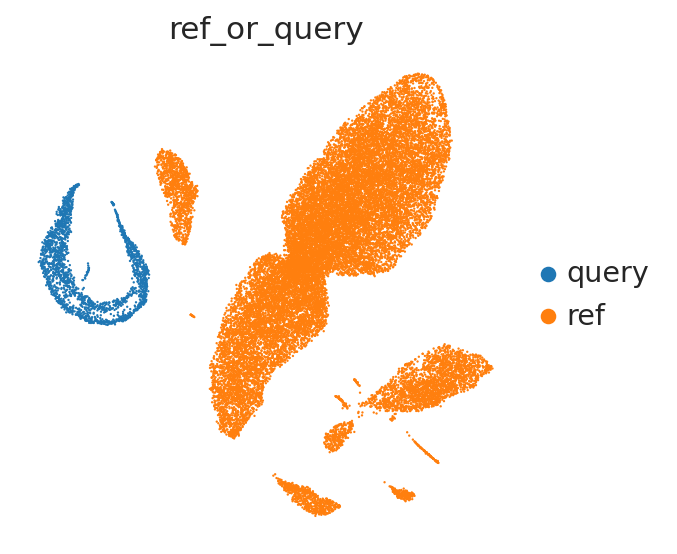

In [7]:
sc.pl.umap(combined_emb, color="ref_or_query", frameon=False)

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


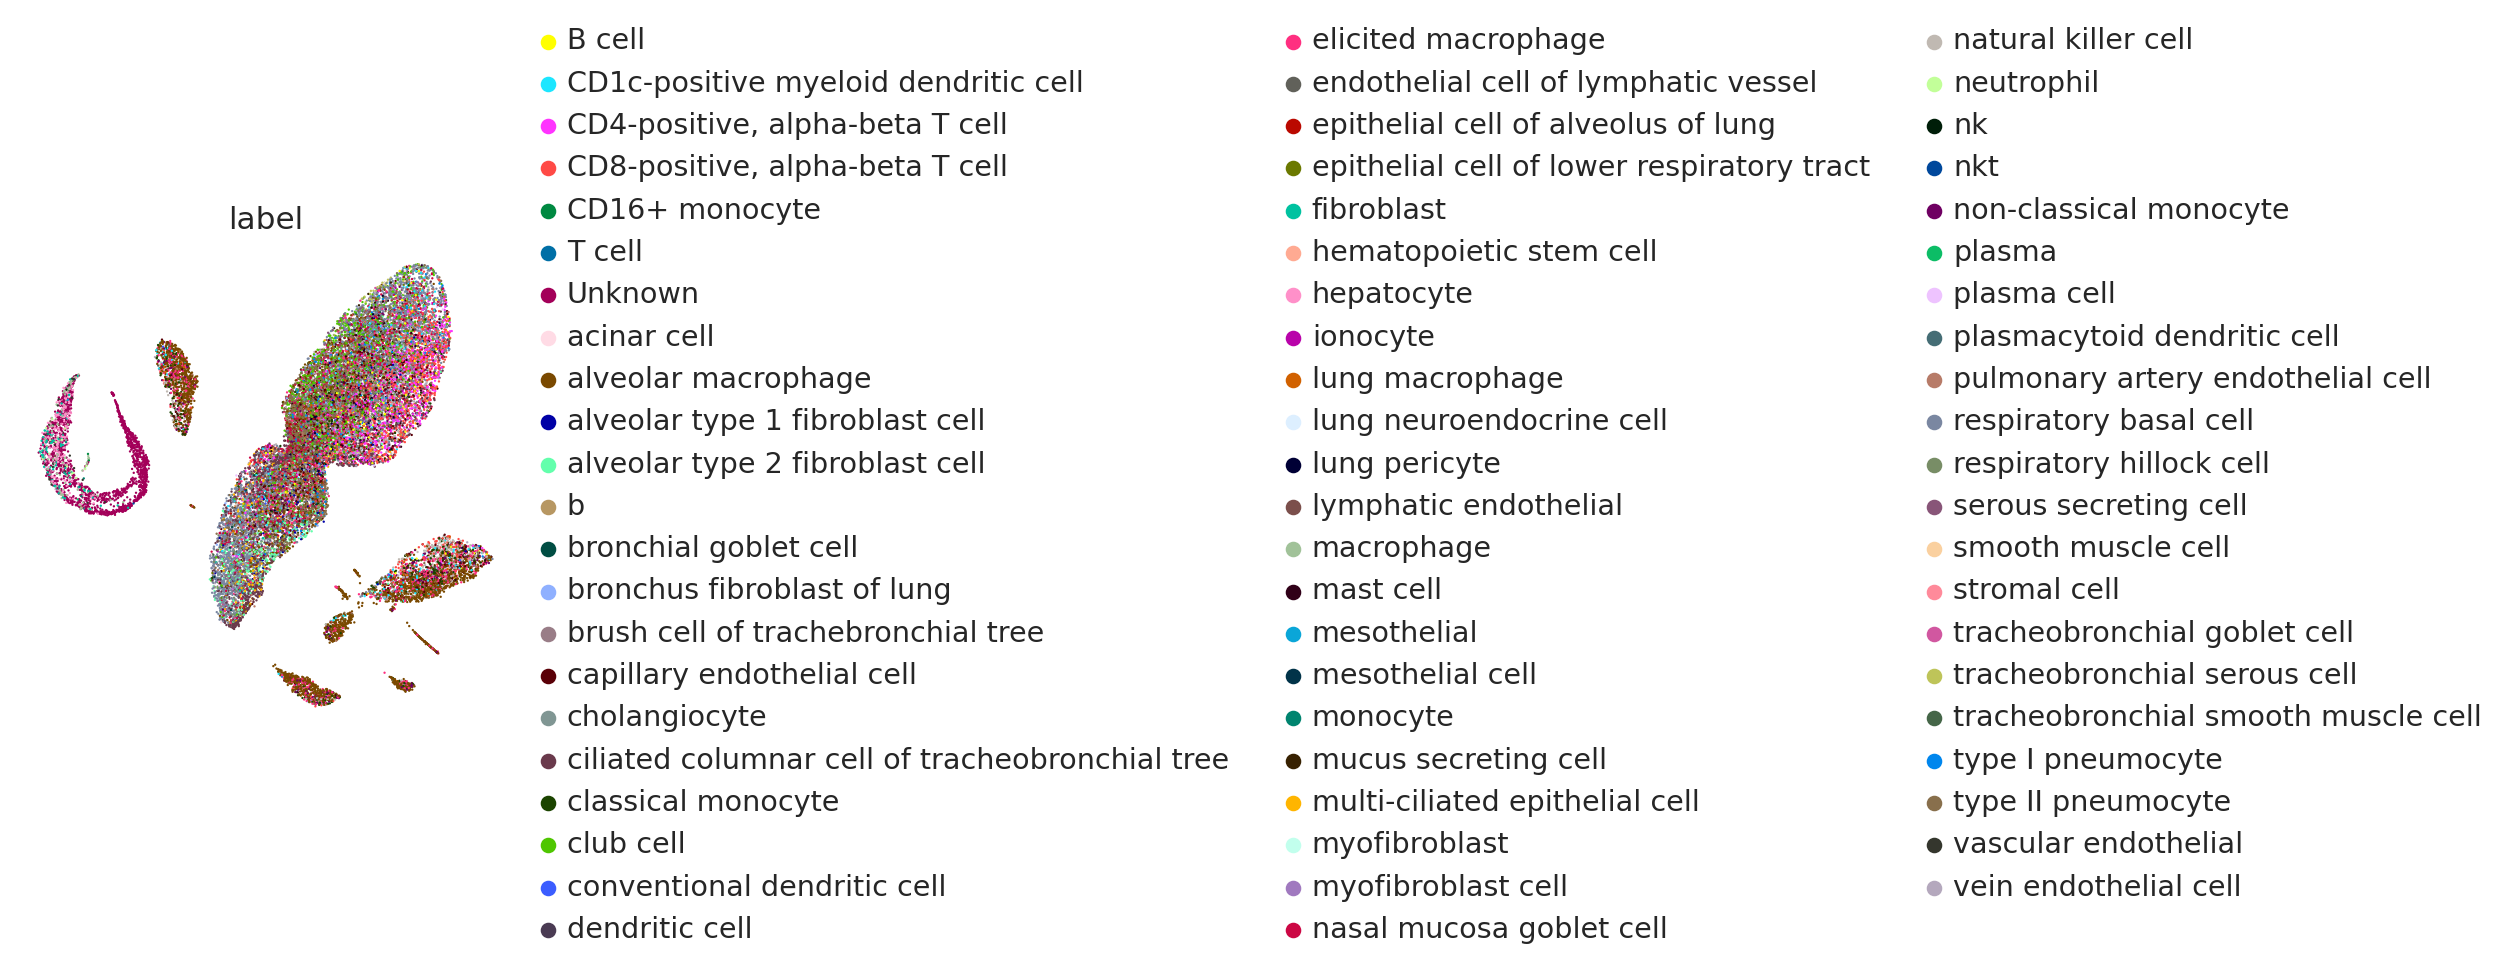

In [8]:
sc.pl.umap(combined_emb, color="label", frameon=False)

# UMAP for Fine-Tuned Embeddings

Repeating the same procedure:

In [9]:
df_query_embd = pd.read_csv("query_embeddings_finetuned.csv", index_col="index")
df_ref_embd = pd.read_csv("reference_25000_embeddings_finetuned.csv", index_col="index")

In [10]:
adata_query_latent = sc.AnnData(df_query_embd[df_query_embd.columns[:-1]])
adata_query_latent.obs["label"] = df_query_embd["label"]
adata_query_latent.obs["ref_or_query"] = "query"
adata_query_latent

AnnData object with n_obs × n_vars = 2142 × 50
    obs: 'label', 'ref_or_query'

In [11]:
adata_ref_latent = sc.AnnData(df_ref_embd[df_ref_embd.columns[:-1]])
adata_ref_latent.obs["label"] = df_ref_embd["label"]
adata_ref_latent.obs["ref_or_query"] = "ref"
adata_ref_latent.obs_names_make_unique()
adata_ref_latent

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 25000 × 50
    obs: 'label', 'ref_or_query'

In [12]:
combined_emb = sc.concat(
    (adata_ref_latent, adata_query_latent), join="outer"
) 

In [13]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


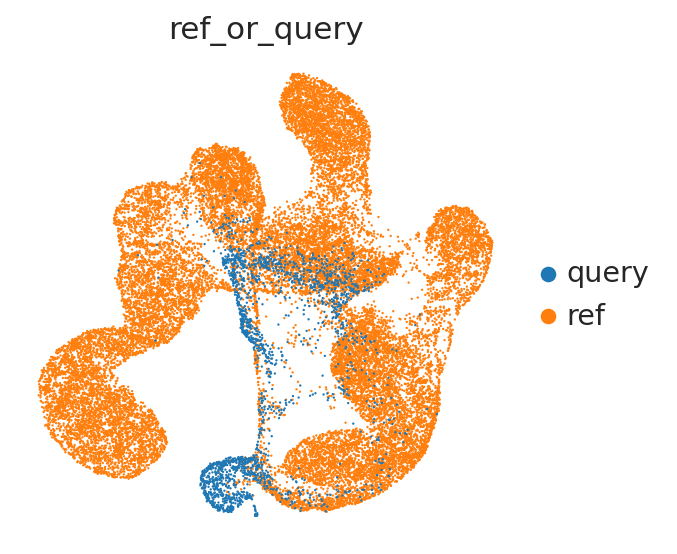

In [14]:
sc.pl.umap(combined_emb, color="ref_or_query", frameon=False)

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


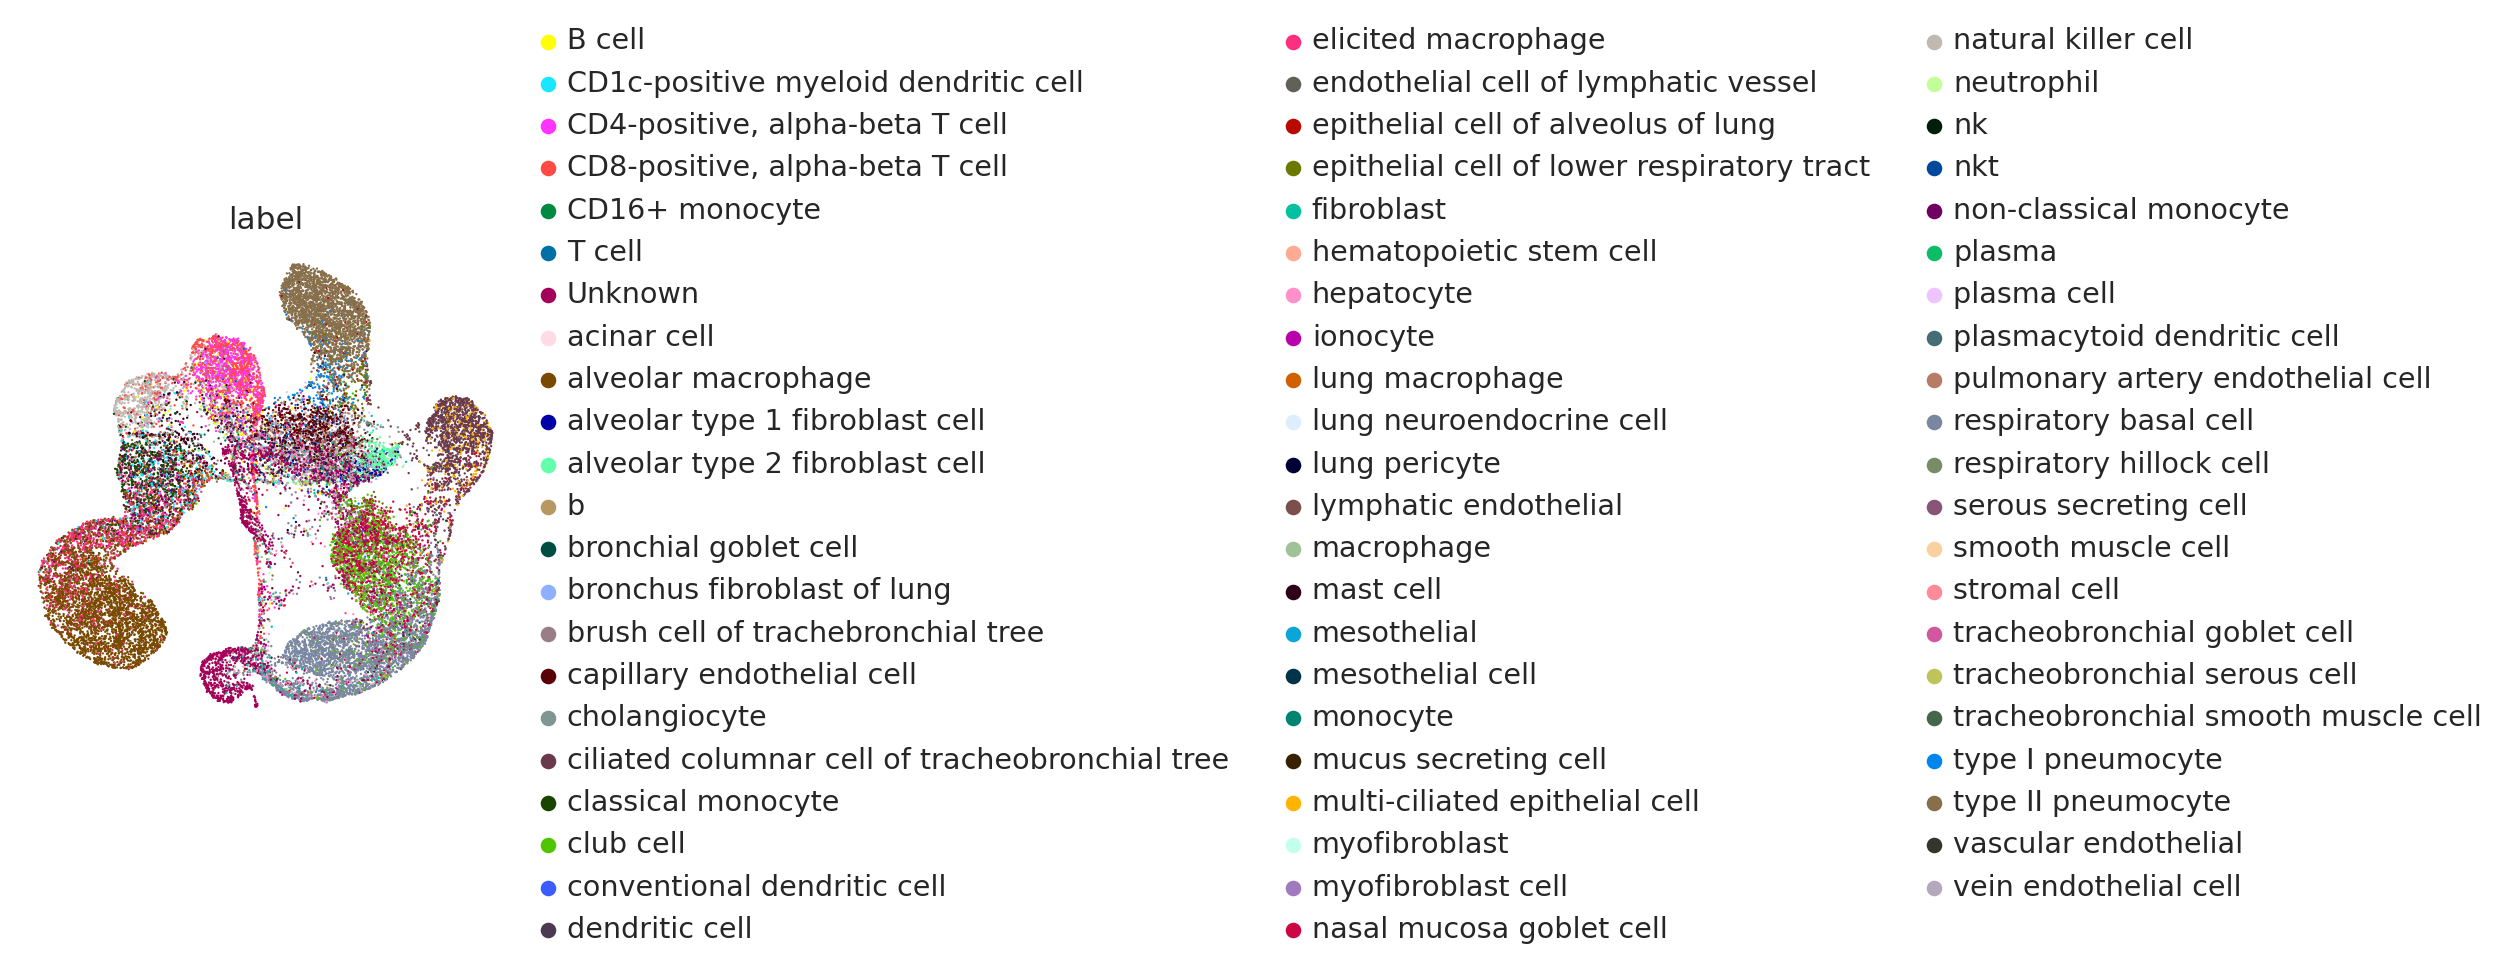

In [15]:
sc.pl.umap(combined_emb, color="label", frameon=False)